<a href="https://colab.research.google.com/github/futartup/S12-assignment/blob/master/K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Add the current path

In [0]:
import os, sys
path_current = '/content/drive/My Drive/Colab Notebooks/S11'
if path_current not in sys.path:
  sys.path.append(path_current)

# Import Libraries

In [0]:
import os, json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from tabulate import tabulate

# Read the files and get the size of each images

In [4]:
from PIL import Image 

size_images = {}
for dirpath, _, filenames in os.walk("/content/drive/My Drive/Colab Notebooks/S11/Data/Dog_images/"):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

print(size_images)

{'img_dog_.jpeg': {'width': 284, 'heigth': 177}, ' .jpg': {'width': 4752, 'heigth': 4752}, 'dog_2.jpg': {'width': 4272, 'heigth': 2848}, 'dog_3.jpg': {'width': 2755, 'heigth': 3665}, 'dog_4.jpg': {'width': 2034, 'heigth': 3615}, 'dog_5.jpg': {'width': 3000, 'heigth': 2000}, 'dog_6.jpg': {'width': 3024, 'heigth': 3738}, 'dog_7.jpg': {'width': 3628, 'heigth': 5474}, 'dog_8.jpg': {'width': 3024, 'heigth': 4032}, 'dog_9.jpg': {'width': 5616, 'heigth': 3744}, 'dog_10.jpg': {'width': 6016, 'heigth': 4016}, 'dog_11.jpg': {'width': 3774, 'heigth': 4717}, 'dog_12.jpg': {'width': 4000, 'heigth': 6000}, 'dog_13.jpg': {'width': 5184, 'heigth': 3456}, 'dog_14.jpg': {'width': 3917, 'heigth': 5867}, 'dog_15.jpg': {'width': 5472, 'heigth': 3648}, 'dog_16.jpg': {'width': 5184, 'heigth': 3456}, 'dog_17.jpg': {'width': 5184, 'heigth': 3456}, 'dog_18.jpg': {'width': 3814, 'heigth': 5722}, 'dog_19.jpg': {'width': 3385, 'heigth': 5078}, 'dog_20.jpg': {'width': 6124, 'heigth': 4082}, 'dog_22.jpg': {'width': 

# Read the annotated file

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/S11/Data/s11_dog_dataset_50.json") as fp:
  file_content = json.load(fp)

# Load the JSON file

In [0]:
def make_clusters(size_images, file_content):
    xx = []
    yy = []
    ZZ = []
    CC = []
    for k, v in file_content.items():
        if 'regions' in v:
          region = v['regions']

          # Bounding box attributes
          w = region[0]['shape_attributes']['width']
          h = region[0]['shape_attributes']['height']
          x = region[0]['shape_attributes']['x']
          y = region[0]['shape_attributes']['y']

          # Image height and width
          image_width = size_images[v['filename']]['width']
          image_height = size_images[v['filename']]['heigth']

          # Normalized bounding boxes
          n_width = w / image_width
          n_height = h / image_height

          # Normalized centers
          n_x = x / image_width
          n_y = y / image_height

          xx.append(n_width)
          yy.append(n_height)
          ZZ.append([n_width,n_height])
          CC.append([n_x,n_y])

    # Determine the best cluster number using elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(ZZ)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Determine the clusters
    cluster_num = 4
    kmeans = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(ZZ)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
    plt.xlabel('Scatter plot for {0} clusters'.format(cluster_num))
    plt.show()


    


    # Plot the bounding boxes
    for pos, val in enumerate(ZZ):
      x = CC[pos][0]
      y = CC[pos][1]
      new_x = x - (val[0]/2)
      new_x = y - (val[1]/2)
      rectangle = plt.Rectangle((new_x,new_x), val[0], val[1], fc='white', ec="red", alpha=0.8)
      plt.gca().add_patch(rectangle)
      plt.axis('scaled')  
    plt.xlabel('All The Normalized Bounding Boxes')
    plt.show()

    # Calculate the IOU and templates
    templates_dict = {}
    for pos, val in enumerate(kmeans.cluster_centers_):
      templates_dict[pos] = val

    for pos, val in enumerate(ZZ):
      # calculate the IOU
      values = templates_dict[pred_y[pos]]
      x_t = values[0]
      y_t = values[1]

      x = ZZ[pos][0]
      y = ZZ[pos][1]

      if x_t < x and y_t < y:
        iou = x*y / x_t * y_t
      elif y_t < y:
        iou = y_t * x / 2*(y_t * (x_t - x)/2) + 2 * ((y_t-y/2) * x)
      else:
        iou = x * y_t / 2*(y_t * (x_t - x)/2) + 2 * ((y_t-y/2) * x)
      ZZ[pos].append(pred_y[pos])
      ZZ[pos].append(iou)
    # Print the cluster centers
    print("\n")
    print("The templates predicted for each normalized bounding boxes and IOU \n")
    print(tabulate(ZZ, headers=['x', 'y', 'Template', 'IOU'], tablefmt='orgtbl'))

    

# Call the function

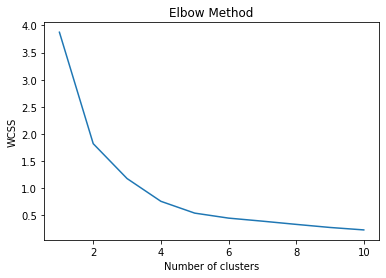

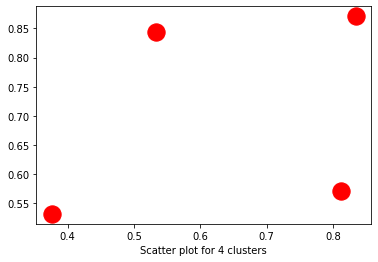

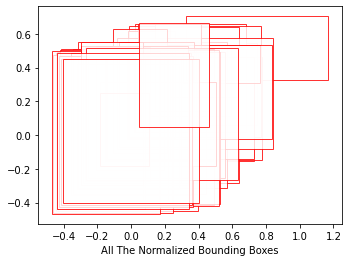



The templates predicted for each normalized bounding boxes and IOU 

|        x |        y |   Template |      IOU |
|----------+----------+------------+----------|
| 0.839436 | 0.377736 |          0 | 0.640017 |
| 0.383333 | 0.666667 |          2 | 0.361778 |
| 0.47823  | 0.418188 |          2 | 0.305487 |
| 0.690381 | 0.488404 |          0 | 0.458363 |
| 0.66175  | 0.635131 |          0 | 0.343802 |
| 0.329333 | 0.488    |          2 | 0.190853 |
| 0.87963  | 0.61771  |          0 | 0.382174 |
| 0.925028 | 0.61308  |          0 | 0.398886 |
| 0.782738 | 0.659474 |          0 | 0.379881 |
| 0.391204 | 0.533387 |          2 | 0.295394 |
| 0.274767 | 0.634462 |          2 | 0.12005  |
| 0.414414 | 0.412974 |          2 | 0.268755 |
| 0.9235   | 0.804833 |          1 | 0.849566 |
| 0.320602 | 0.514178 |          2 | 0.177599 |
| 0.847332 | 0.935742 |          1 | 0.827219 |
| 0.885234 | 0.86568  |          1 | 0.766922 |
| 0.871721 | 0.608218 |          0 | 0.372918 |
| 0.711034 | 0.93

In [92]:
make_clusters(size_images, file_content)